### Principles of Superconducting Quantum Computers
Daniel D. Stancil, Gregory T. Byrd, Wiley, 2022  ISBN: [978-1119750727](https://bcs.wiley.com/he-bcs/Books?action=index&bcsId=12203&itemId=1119750725)

----

## Chapter 1: Qubits, Gates, and Circuits
## Deutsch's Problem

[David Deutsch](https://en.wikipedia.org/wiki/David_Deutsch) is a pioneer in the field of quantum computation. He developed the *quantum Turing machine*, which describes any computation that can be performed on a quantum computer. In 1985, he described this very simple problem that can be solved more efficiently with a quantum computer than with classical hardware. To be fair, "more efficiently" here means one evaluation of a black-box function rather than two, so it's not a big computational breakthrough. But it's the first instance of a problem for which quantum is shown to have a proven advantage. It also illustrates an interesting technique for quantum programs, known as *phase kickback*.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.quantum_info import Statevector, Operator
from qiskit import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector

def binstring(n, bits):
    s = ""
    for b in range(bits-1, -1, -1):
        s += str((n >> b) & 1)
    return s
        

def print_state_vector(sv):
    bits = sv.num_qubits
    vals = sv.dim
    for i in range(0, vals):
        #print_bin(i, bits)
        mag = np.abs(sv.data[i])
        ph = np.angle(sv.data[i], True)  # degrees
        print("{:s}: {:.3f}  mag={:.3f} phase={:.3f} ({:3.2%})".format(binstring(i, bits), sv.data[i], mag, ph, mag**2))

#### A Binary Function

We start with the simple idea of a binary function, one that maps a one-bit input to a one-bit output: $f: \{0,1\} \mapsto \{0,1\}$. The function can either be *constant* (always produces 0, or always produces 1) or it can be *balanced* (produces 0 for one input and 1 for the other). There are four such functions:

$$ \begin{array} \\f_0(x) &= &0 \\ f_1(x) &= &1 \\ f_2(x) &= &x \\ f_3(x) &= &\overline{x} \end{array} $$

It should be clear that $f_0$ and $f_1$ are constant, while $f_2$ and $f_3$ are balanced. However, the first two functions are not reversible, so they are not suitable for implementation on a quantum computer. To make them reversible, we introduce an additional parameter $y$, and we compute the output as the XOR of $y$ with $f_i(x)$.  Recasting these using unitary operators ($U_i$) and qubit states ($|x,y\rangle$), we have:

$$ U_i|x,y\rangle = |x, f_i(x) \oplus y \rangle $$

If the input state $|y\rangle = |0\rangle$, then the low-order bit will hold the value of $f_i(x)$. In the steps below, we want to treat this function as a black box, also known as an *oracle*, so we will create a set of quantum circuits to implement them. (See Figure 1.10.)

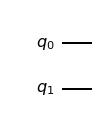

In [2]:
qc0 = QuantumCircuit(2,name='U_0')  # quantum circuit for U_0
# nothing to do -- f0(x) = 0, so output is just y
qc0.draw('mpl')

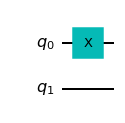

In [3]:
qc1 = QuantumCircuit(2,name='U_1')  # quantum circuit for U_0
# f0(x) = 1, so output is flipped y
qc1.x(0)
qc1.draw('mpl')

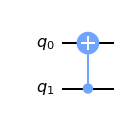

In [4]:
qc2 = QuantumCircuit(2,name='U_2')  # quantum circuit for U_0
# f0(x) = x, so output is just y XOR x
qc2.cx(1,0)
qc2.draw('mpl')

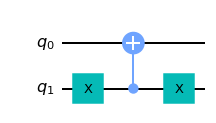

In [5]:
qc3 = QuantumCircuit(2,name='U_3')  # quantum circuit for U_0
# f0(x) = not(x), so output is y XOR not(x)
qc3.x(1)
qc3.cx(1,0)
qc3.x(1)  # uncompute, so that x is restored
qc3.draw('mpl')

We'll create a list of these circuits, so that we can easily choose one to insert into the Deutsch circuit below.

In [6]:
fc = [qc0, qc1, qc2, qc3]

#### Using Superposition

The problem we're trying to solve is this: Given an unknown binary function $f_i(x)$, is the function constant or balanced?

With classical hardware, we would have to execute the function twice -- once for each input (0 and 1) -- and compare the outputs. With quantum hardware, we can exploit *superposition* and *phase* to answer the question with **one** execution of the function.

First, let's consider superposition. If we prepare $x$ as an equal superposition of $|0\rangle$ and $|1\rangle$, and we set $|y\rangle = |0\rangle$, then the output will be a superposition of $f_i(0)$ and $f_i(1)$.  Therefore, if the output state is a "pure" $|0\rangle\$ or $|1\rangle$, then we know that the output is the same for both input values. If the output is a superposition, we know that the output depends on the input, and the function is therefore balanced.

However, if we only run the experiment once, and we measure the output, then we will see either 0 or 1. We can't tell if we have a superposition output unless we run the experiment multiple times to see different outputs. So this doesn't seem any better than the classical solution. In fact, it's worse than the classical solution, because executing the function twice only *probabilistically* gives us different measurements of a superposition.

To illustrate, let's try one of the balanced functions in the Qiskit simulator.

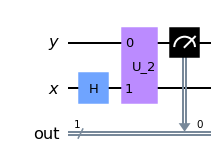

In [7]:
x = QuantumRegister(1, 'x')
y = QuantumRegister(1, 'y')
m = ClassicalRegister(1, 'out')
circ2 = QuantumCircuit(y, x, m)
circ2.h(x)   # prepare x as 0 + 1
circ2.append(fc[2], y[:]+x[:])  # use f2 as black box function -- output should be 0 + 1
circ2.measure(y, m)  # measure y to look at its value
circ2.draw('mpl')

Simulate the circuit once.  We will see 0 or 1 as the output, but we don't know which.  (Evaluate the next cell multiple times to see that we get different outputs with different runs.)

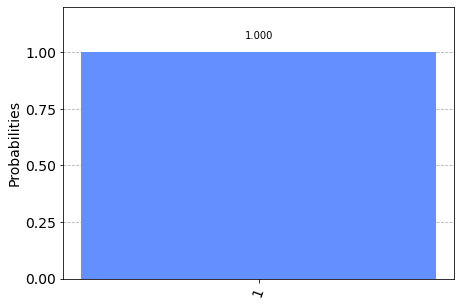

In [8]:
sim = Aer.get_backend('qasm_simulator')
job = execute(circ2, sim, shots = 1)
counts = job.result().get_counts()
plot_histogram(counts)

If we execute and measure twice, we might see a superposition, but we might not. (Again, run the next cell a few times to observe different probabilistic outputs.)

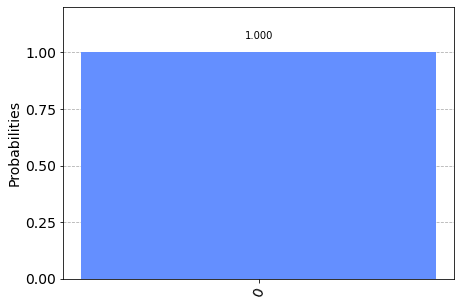

In [9]:
job = execute(circ2, sim, shots = 2)
counts = job.result().get_counts()
plot_histogram(counts)

We have to run a bunch of times to have a good chance of seeing the superposition. This is worse than the classical approach. We'd be better off running the quantum circuit twice, with $|x\rangle = |0\rangle$ and $|x\rangle = |1\rangle$.

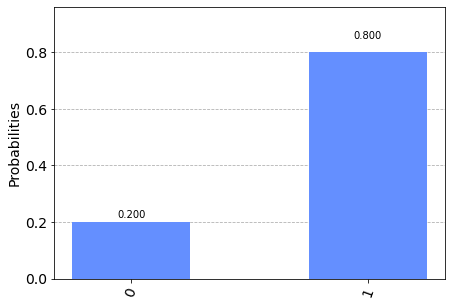

In [10]:
job = execute(circ2, sim, shots = 10)
counts = job.result().get_counts()
plot_histogram(counts)

#### Phase Kickback

With quantum, we are not limited to classical states like 0 and 1. In addition to superposition, the complex coefficients (amplitudes) can have phases. We use the term *local phase* or *relative phase* to indicate that there are different phases for the basis states. For example, the following quantum state has a local phase of $\pi/2$:

$$ \frac{1}{\sqrt{2}} ( |0\rangle + e^{i\pi/2}|1\rangle ) $$

However, if we initialize $|y\rangle$ as a superposition state with a local phase between the $|0\rangle$ and $|1\rangle$ states, then something interesting happens. When such a state is the target of a CNOT gate, the phase effectively gets transferred to the *control* signal. This phenomenon is known as *phase kickback*.

For example, consider applying a CNOT gate to an initial state $|-1\rangle$. The target has a phase of $\pi$, because $e^{i\pi} = -1$. For the math below, assume that qubit 0 is the control and qubit 1 is the target.

$$ \begin{array} {rcl}
\mathrm{CX}|-1\rangle &= &\mathrm{CX}(|-\rangle \otimes |1\rangle \\
&= &\mathrm{CX}(\frac{1}{\sqrt{2}}|01\rangle - \frac{1}{\sqrt{2}}|11\rangle \\
&= &\frac{1}{\sqrt{2}}(|11\rangle - |01\rangle) \\
&= &-|-\rangle \otimes |1\rangle\\
&= &|-\rangle \otimes -|1\rangle
\end{array} $$

Comparing the first line to the last line, you can see that one interpretation is that the target qubit stays the same and the phase is transferred to the control qubit.

This is even more evident when the control qubit itself is a superposition:

$$ \begin{array} {rcl}
\mathrm{CX}|-+\rangle &= &\mathrm{CX}(|-\rangle \otimes |+\rangle) \\
&= &\frac{1}{\sqrt{2}}(\mathrm{CX}(|-\rangle \otimes |0\rangle) + \mathrm{CX}(|0\rangle \otimes |1\rangle)) \\
&= &\frac{1}{\sqrt{2}}((|-\rangle \otimes |0\rangle) + (|-\rangle \otimes -|1\rangle)) \\
&= &\frac{1}{\sqrt{2}}((|-\rangle \otimes |0\rangle) - (|-\rangle \otimes |1\rangle)) \\
&= &|-\rangle \otimes \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle) \\
&= &|-\rangle \otimes |-\rangle
\end{array} $$

As before, the phase from the target has been "transferred" to the control, changing it from $|+\rangle$ to $|-\rangle$.

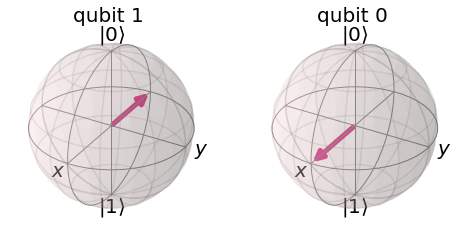

00: 0.500+0.000j  mag=0.500 phase=0.000 (25.00%)
01: 0.500+0.000j  mag=0.500 phase=0.000 (25.00%)
10: -0.500+0.000j  mag=0.500 phase=180.000 (25.00%)
11: -0.500+0.000j  mag=0.500 phase=180.000 (25.00%)


In [11]:
sv = Statevector.from_label("-+")
display(plot_bloch_multivector(sv, reverse_bits=True))
print_state_vector(sv)

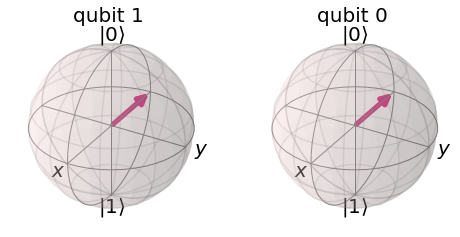

00: 0.500+0.000j  mag=0.500 phase=0.000 (25.00%)
01: -0.500+0.000j  mag=0.500 phase=180.000 (25.00%)
10: -0.500+0.000j  mag=0.500 phase=180.000 (25.00%)
11: 0.500+0.000j  mag=0.500 phase=0.000 (25.00%)


In [12]:
cnot = Operator([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])  # CNOT with qubit 0 as control
sv = sv.evolve(cnot)
display(plot_bloch_multivector(sv, reverse_bits=True))
print_state_vector(sv)

#### Deutsch Circuit: Superposition plus Phase Kickback
Now, getting back to solving the Deutsch problem...

If we initialize $|y\rangle = |-\rangle$, we have a superposition with a local phase. For the two balanced functions ($f_2$ and $f_3$), the CNOT transfers that phase to make $|x\rangle = |+\rangle \mapsto |-\rangle$. For the two constant functions ($f_0$ and $f_1$), there is no CNOT and no phase transfer, so $|x\rangle$ remains unchanged as $|+\rangle$.

We can distinguish $|+\rangle$ from $|-\rangle$ by applying a Hadamard and then measuring. For $|+\rangle$, the Hadamard changes to the state to $|0\rangle$, and we will always measure 0. For $|-\rangle$, the Hadamard changes the state to $|1\rangle$, and we will always measure 1.

Therefore, we can execute the circuit once and be 100% sure that we can distinguish the constant and balanced functions.

**NOTE:** In the circuits below, we measure the $x$ qubit, not the $y$ qubit.  
Output 0 ==> constant  
Output 1 ==> balanced

In [13]:
def deutsch_circuit(i):  # use function f_i in Deutsch circuit
    x = QuantumRegister(1, 'x')
    y = QuantumRegister(1, 'y')
    m = ClassicalRegister(1, 'out')
    circ = QuantumCircuit(y, x, m)
    circ.h(x)   # prepare x as 0 + 1
    circ.barrier()  # just to separate the x and y prep 
    circ.x(y)   # prepare y as 0 - 1
    circ.h(y)
    circ.append(fc[i], y[:]+x[:])  # use f as black box function 
    circ.h(y)   # uncompute y to make it zero again (not necessary in this case, but good practice)
    circ.x(y)
    circ.barrier()
    circ.h(x)   # convert x for measurement
    circ.measure(x, m)  # measure x to look at its value
    display(circ.draw('mpl'))
    job = execute(circ, sim, shots = 1)
    counts = job.result().get_counts()
    display(plot_histogram(counts))

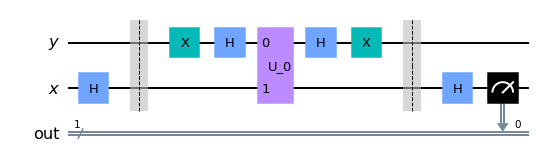

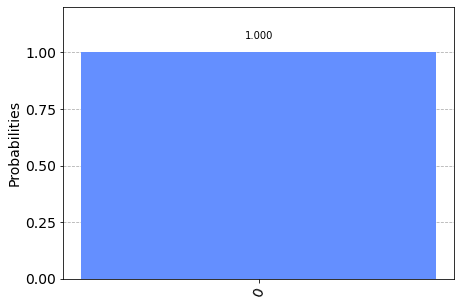

In [14]:
deutsch_circuit(0)   # f_0: constant

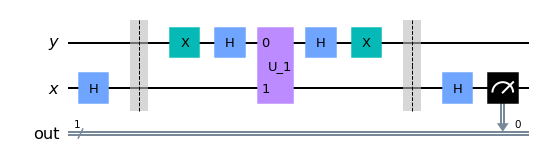

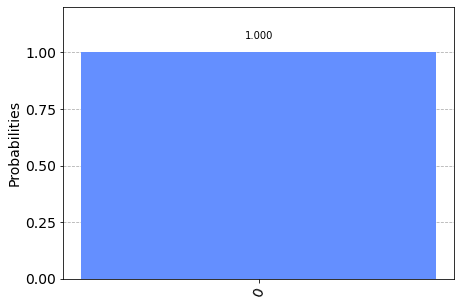

In [15]:
deutsch_circuit(1)  # f_1: constant

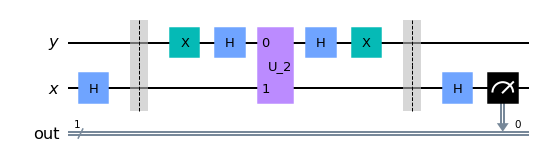

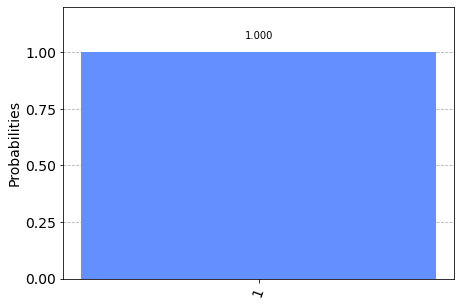

In [16]:
deutsch_circuit(2)  # f_2: balanced

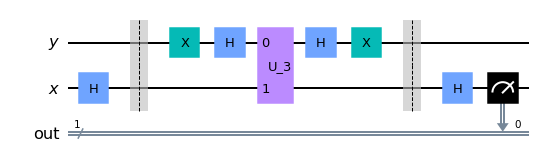

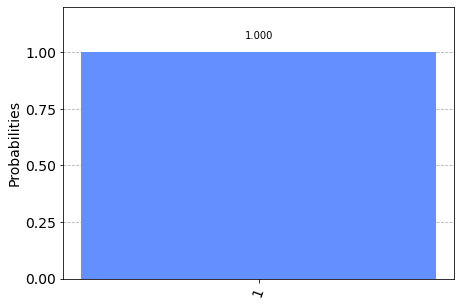

In [17]:
deutsch_circuit(3)  # f_3: balanced

#### Extension to more bits: Deutsch-Josza
In 1992, Deutsch and Richard Josza extended this algorithm to work for a many-to-one binary function that is either balanced or constant. In other words, the function $f$ takes an $n$-bit value and produces one bit of output. The function is constant if it always produces the same answer, and it is balanced if it produces 0 for exactly half of the input values and 1 for the other half.

With classical computing, there are $2^n$ different inputs and you'd have to evaluate the function up to $2^{n-1}$ times to know whether it's constant or not. Using superposition and phase kickback, the Deutsch-Josza algorithm provides the answer with just one evaluation of the function. This is an *exponential* speedup!

The Qiskit textbook has a very nice discussion of the [Deutsch-Josza algorithm](https://learn.qiskit.org/course/ch-algorithms/deutsch-jozsa-algorithm).


----

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table